In [44]:
import MDAnalysis as mda
import numpy as np
import sys
import matplotlib.pyplot as plt
#nav = mda.units.N_Avogadro

from datetime import date
today = date.today()

import yaml
import os
import fnmatch

import time
import gc
gc.collect()


1423

In [8]:
print(today)

2022-04-13


In [50]:
class FormFactor(object):
    """
    Calculates form factors from density profiles.
    
    Further development will include thickness of the membrane 
    from the intersection of lipid density and water density.
    Already enables to calculate electrom/mass/number densities
    
    Density could be calculated only from the final form factor profile 
    - testing is needed to see stability for rare species.
    
    Examination of FF error spikes is needed!
    
    """
    def __init__(self, path,name,nbin,bsize,output,center,group,density_type="electron"):
        self.conf = path+name+'/'+name+".gro"
        self.traj = path+name+'/'+name+".xtc"
        start_time=time.time()
        self.uni = mda.Universe(self.conf,self.traj)
        
        print("Loading the trajectory takes {:10.6f} s".format(time.time()-start_time))
        
        #group to calculate  mass or number densities - should be extended to more than 1 group!
        self.u = self.uni.select_atoms(group)
        self.group=group
        
        #number of bins
        self.nbin = nbin
        #the totatl box size in [nm] - will be probably removed and tpr box size or 
        #transform of final FF will be used instead
        self.bsize = bsize
        self.output = output
        self.center = center
        
        
        readme = path+name+ "/README.yaml"
        with open(readme) as yaml_file:
            content = yaml.load(yaml_file, Loader=yaml.FullLoader)
        
        self.readme=content
        
        self.density_type = density_type
        
        self.calculate_weight()
        

        self.calculate_density()
        
    def calculate_weight(self):
        """
        Creates an array of weights for all atoms in the simulation.
        
        For electron densities:
         - creates dictonary of atom types and number of electrons
           loaded form an external file --> in the future it backmaps 
                                            the atom names to mapping files
                                            and automaticaly assigns # of electrons
                                            
        Number densities:
         - all weights are 1
         
        Mass densities:
         - reads masses from u.atoms.masses
        """
        start_time=time.time()
        if self.density_type=="electron":
            with open ('electrons.dat') as f:
                rawdata = f.read().split('\n')
                lines= rawdata[0:len(rawdata)-1]
                tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
                electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
        
            #weights to calculate the electron density
            wght=np.zeros(self.u.atoms.names.shape[0])
            for i in range (0,self.u.atoms.names.shape[0]):
                wght[i]=electrons[self.u.atoms.names[i]]
            self.wght=wght
        if self.density_type=="number":
            self.wght=np.ones(self.u.atoms.names.shape[0])
        if self.density_type=="mass":
            self.wght=self.u.atoms.masses
            
        print("Creating the electron mapping dictonary takes {:10.6f} s".format(time.time()-start_time))

    def calculate_density(self):

        
        c = self.uni.select_atoms(self.center)

        
       
        
        
        box_z = self.u.dimensions[2]

 
        min_z = box_z   # used to search for the min box size to cut off the profile on the edges

        self.nbin=int(box_z*3)
        boxH = box_z/10
        d = boxH/ self.nbin


        x = np.linspace(-boxH/2,boxH/2,self.nbin+1)[:-1] + d/2
        fx = np.zeros(self.nbin)
        fa=[]
        fb=[]

        """Calculte density profiles and FF from individual frames"""
        start_time=time.time()
        begin_analysis=int(int(self.readme['BINDINGEQ'])/int(self.readme["FILES"]['xtc']['TIMESTEP']))
        beginning_time=begin_analysis #self.uni.trajectory.time
        for ts in self.uni.trajectory[begin_analysis:]:
            #count the index of the frame, numbered from 0, used to be used for the density profile averaging
            #posible not needed now
            frame = ts.frame
            end_time = ts.time
            

            
            #reads the dimension in z-direction
            box_z = ts.dimensions[2]
            if box_z/10<min_z:
                min_z=box_z/10
            
            #print(min_z)

            #deal with the one problematic simulation
            self.problem="no"
            if self.problem=="yes":
                crds = self.uni.atoms.positions+100
                self.uni.atoms.positions= crds
                self.uni.atoms.pack_into_box()

                self.c = self.uni.select_atoms("resname POPC")
                self.u = self.uni.select_atoms(self.group)


            
            #reads the coordinates of all of the atoms
            crds = self.u.atoms.positions
            
            #calculates the center of mass of the selected atoms that the density should be centered around and 
            #takes the z-coordinate value
            ctom = c.atoms.center_of_mass()[2]
            
            #moves the center of mass of the selected centering group into box/2
            crds[:,2] += box_z/2 - ctom
            
            """shifts the coordinates in the universe by the value of the center of mass"""
            self.u.atoms.positions = crds
            
            """puts the atoms back to the original box dimension; it possibly does not take PBC into account
            #therefore it may brake some of the water molecules; try it, come to the issue later"""
            self.u.atoms.pack_into_box()
            
            """shif the coordinates so that the center in z-dimention is in 0; 
            #divide by 10 to get the coordinates in nm, since now the crds are only the z coordinates"""
            crds = (self.u.atoms.positions[:,2] - box_z/2)/10
            
            #gets the box-z size in nm
            box_z /= 10
            
            """calculates the volume of the bin; d- the "height" of a bin; assumes in [nm] """
            # ts.dimension[0], ts.dimension[1] - the x and y dimension; in [A] --> devides by 100
            vbin = d*np.prod(ts.dimensions[:2])/100
            
            #start_time2=time.time()

            
            
            

            """calculates the total density profile; keep for now"""
            fx += np.histogram(crds,bins=self.nbin,range=(-boxH/2,boxH/2),weights=self.wght/vbin)[0]
           
        print("Calculating the density takes {:10.6f} s".format(time.time()-start_time))


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Normalizing the profiles """
        fx /= (frame+1-begin_analysis) 
        
        

        """ Symmetrizing profile if necessary """
        #if args.symmetrize :
        #    fx += fx[::-1]
        #    fx /=2


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Post-processign data and writing to file """
        density_data = np.vstack((x,fx)).transpose()
        
        
        """Post-processing of FF data from individual runs"""
        
        
    
        
        
       
        """Get the indexes of the final density data where all the time steps contribute
        In other words, take the coordinates of the smalest box from the simulation"""
        final_FF_start=int(np.round(self.nbin/2-min_z/d/2))+1
        final_FF_end=int(np.round(self.nbin/2+min_z/d/2))-1
        
  
        
       
        """Plot density profiles from the average density with minimal box"""
        self.plot_density(density_data[final_FF_start:final_FF_end,:])
        self.plot_density(density_data)
        
        
        with open(str(self.output)+".finalDensity", 'w') as f:
            f.write("# Density profile calculated from '{}'\n".format(self.traj))
            f.write("# Density profile of '{}'\n".format(self.group))
            f.write("# Density centered around '{}'\n\n".format(self.center))
            
            f.write("# Beginning time: {} ns \n# End time: {} ns \n".format(beginning_time/1000,end_time/1000))
            f.write("# Time Step: {} ns \n\n".format(self.uni.trajectory[2].time/1000-self.uni.trajectory[1].time/1000))
            
            f.write("# Analyzed by R Nencini, ricky.nencini@helsinki.fi / nencini.ricky@gmail.com \n")
            f.write("# Analyzed on '{}'\n\n".format(today))

            
            #np.savetxt(f, density_data,fmt='%8.4f  %.8f')
            np.savetxt(f, density_data[final_FF_start+1:final_FF_end-1,:],fmt='%8.4f  %.8f')
        
        """Save data into files"""
        
        
        
    def plot_density(self,data):
        #data=np.loadtxt(self.output)
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
        

    
   
        

 
               



In [20]:
path="/DATA/hector/200POPC_PN_NAs150mM/"
name="PN_model_310K_TIP3P_ECC_ions_154mM_sodium"

topology=path+name+'/'+name+".gro"
trajectory=path+name+'/'+name+".xtc"

Loading the trajectory takes   0.307990 s
Creating the electron mapping dictonary takes   0.000157 s
Calculating the density takes  55.409373 s


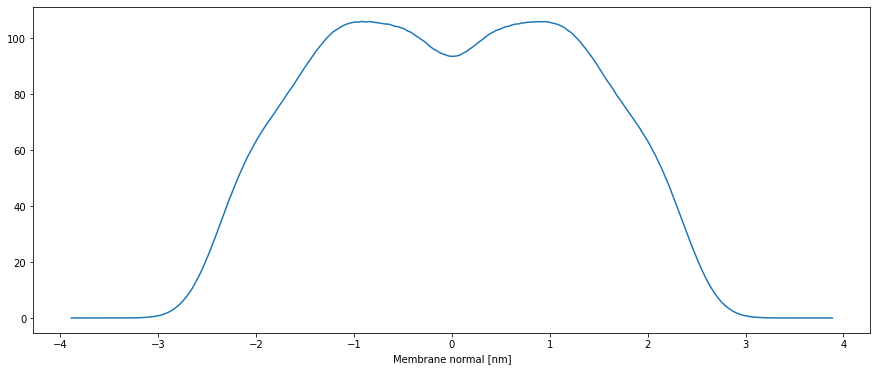

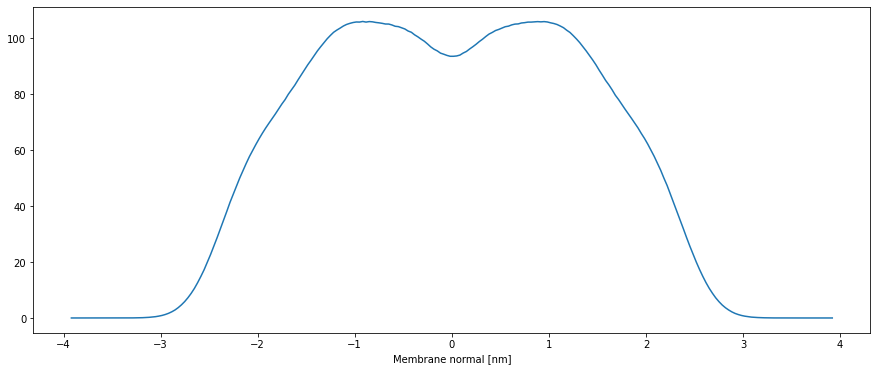

Loading the trajectory takes   0.290520 s
Creating the electron mapping dictonary takes   0.000020 s
Calculating the density takes  36.647547 s


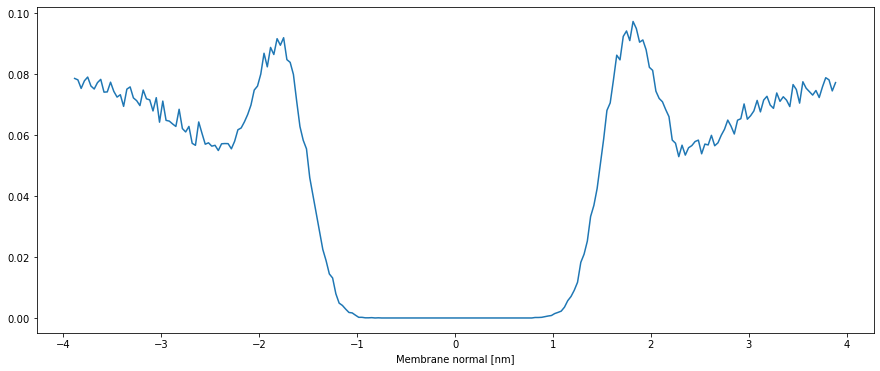

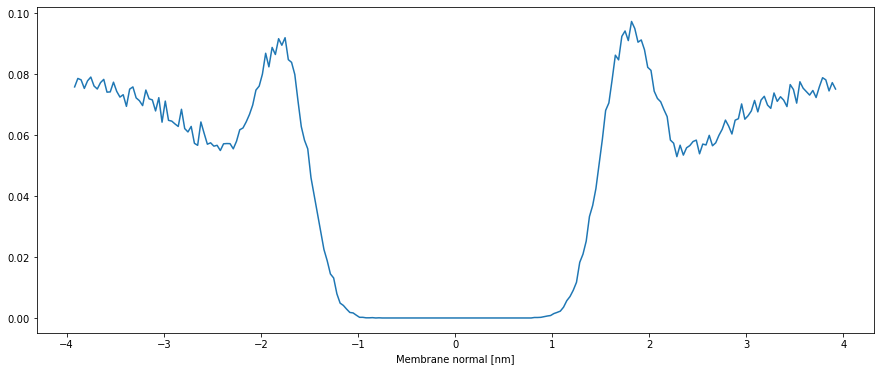

Loading the trajectory takes   0.290982 s
Creating the electron mapping dictonary takes   0.000137 s
Calculating the density takes  55.849168 s


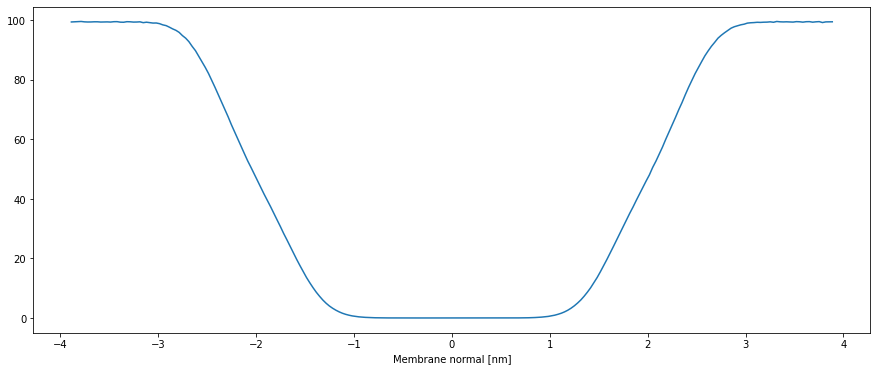

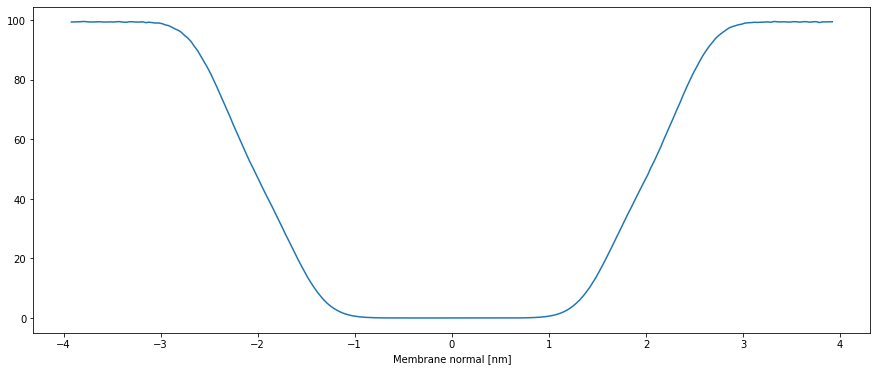

In [21]:
FormFactor(path,name,200,5,'PN_model_310K_TIP3P_ECC_ions_154mM_sodium_PC2',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,'PN_model_310K_TIP3P_ECC_ions_154mM_sodium_NA2',"resname POPC","resname NA","number")
FormFactor(path,name,200,5,'PN_model_310K_TIP3P_ECC_ions_154mM_sodium_SOL2',"resname POPC","resname SOL","number")

In [27]:
path="/media/nenciric/Ricky20201/2020/simulations/"
name="etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_177600waters_paramchem_simulation2_run2022"

topology=path+name+'/'+name+".gro"
trajectory=path+name+'/'+name+".xtc"

a=mda.Universe(topology,trajectory)


Loading the trajectory takes   3.468120 s
Creating the electron mapping dictonary takes   0.000146 s
Calculating the density takes 969.451460 s


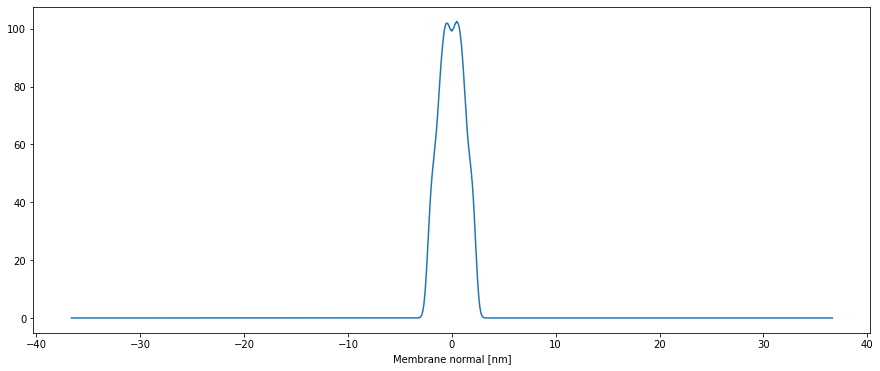

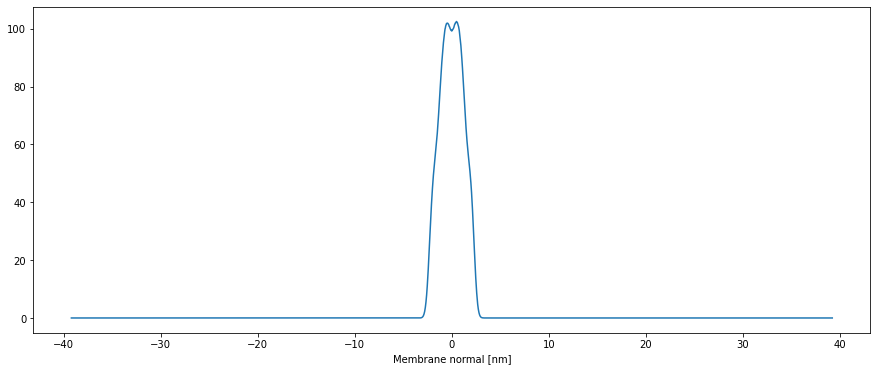

Loading the trajectory takes   3.611421 s
Creating the electron mapping dictonary takes   0.000224 s
Calculating the density takes 918.476283 s


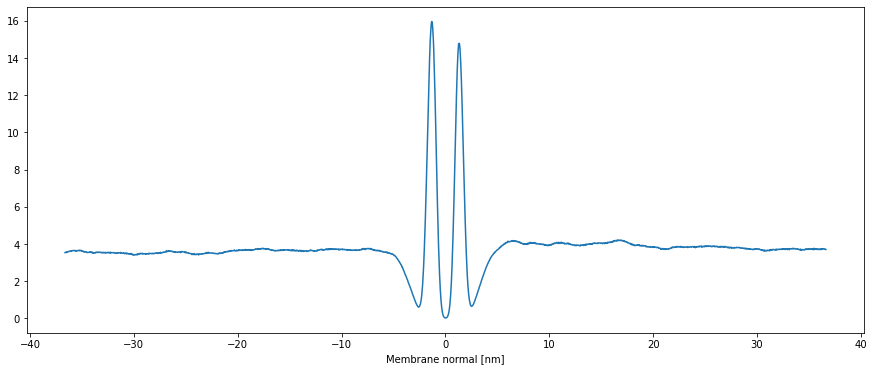

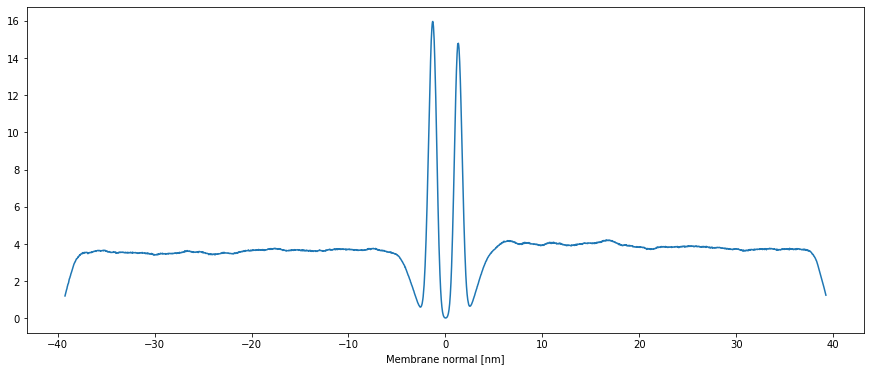

Loading the trajectory takes   3.526145 s
Creating the electron mapping dictonary takes   0.000032 s
Calculating the density takes 904.649840 s


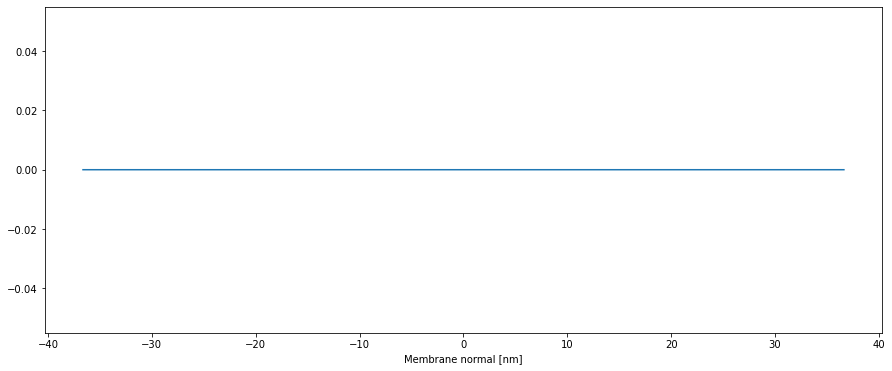

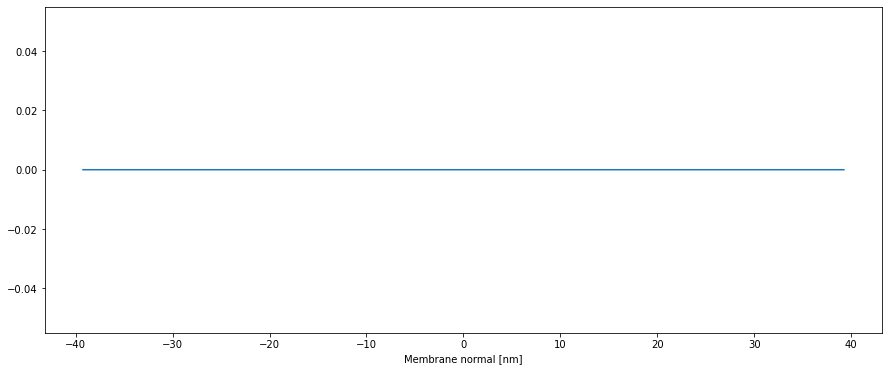

In [34]:
FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_NA',"resname POPC","resname ETI","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname SOL","number")

Loading the trajectory takes   1.137192 s
Creating the electron mapping dictonary takes   0.000265 s
Calculating the density takes 264.538452 s


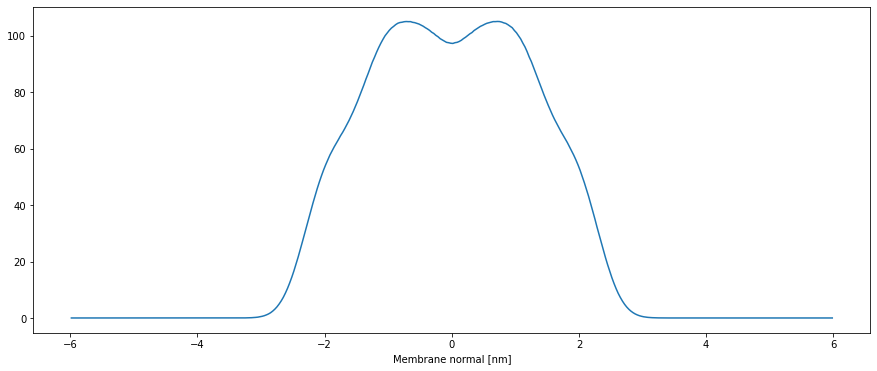

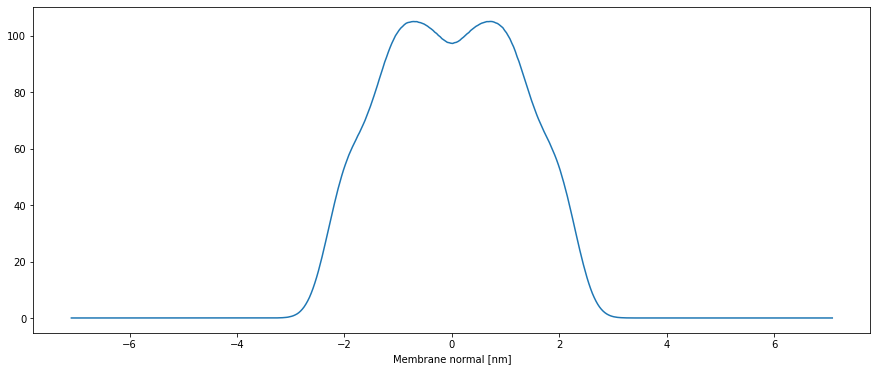

Loading the trajectory takes   0.566558 s
Creating the electron mapping dictonary takes   0.000050 s
Calculating the density takes 153.307214 s


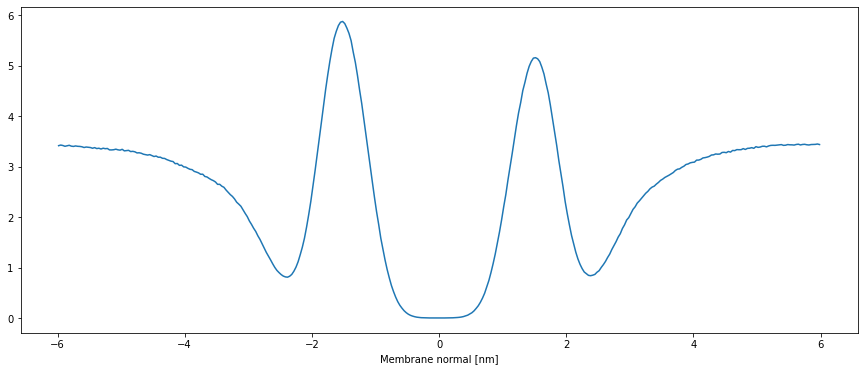

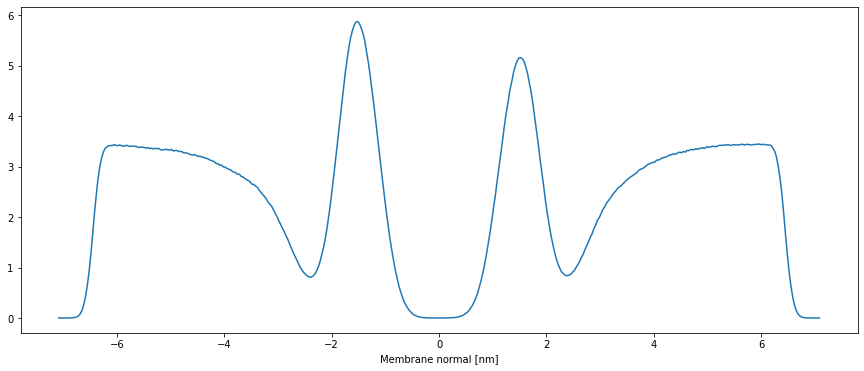

Loading the trajectory takes   0.507940 s
Creating the electron mapping dictonary takes   0.000348 s
Calculating the density takes 278.214947 s


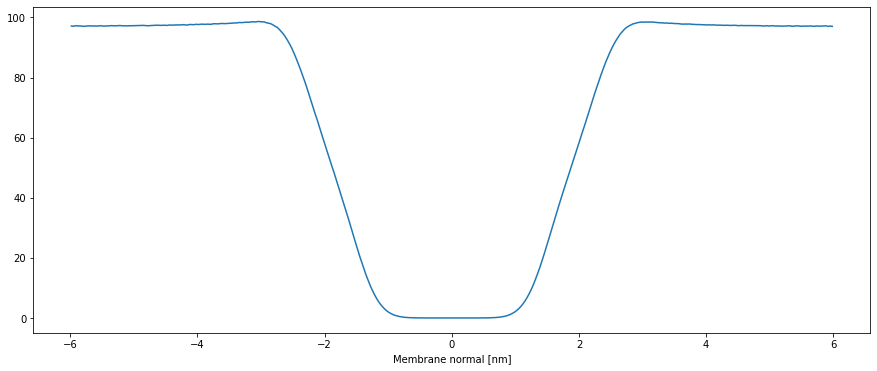

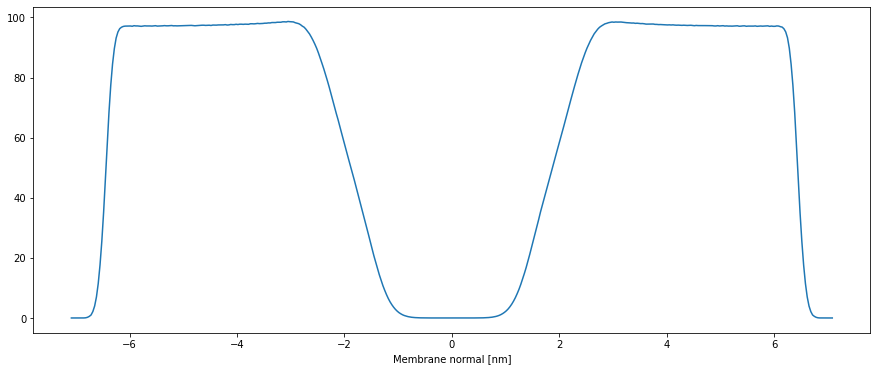

In [23]:
path="/media/nenciric/Ricky2020/simulations/"
name="TPP_POPC_CHARMM36_298K_140mM_20000waters"

FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_TPA',"resname POPC","resname TPA","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname TIP3","number")

Loading the trajectory takes   0.311059 s
Creating the electron mapping dictonary takes   0.000135 s
Calculating the density takes  91.979611 s


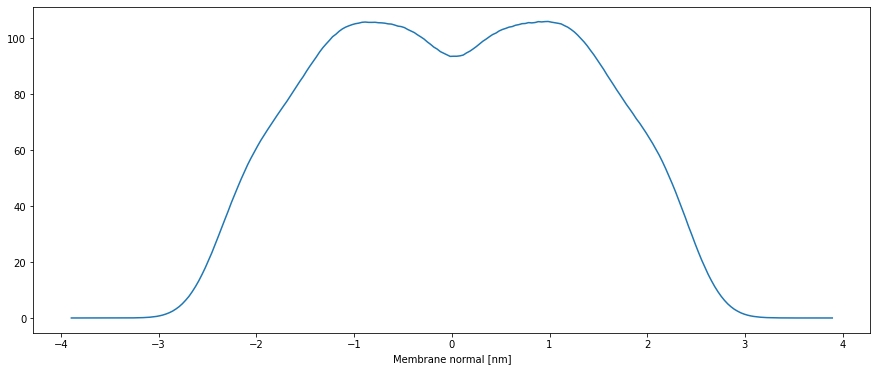

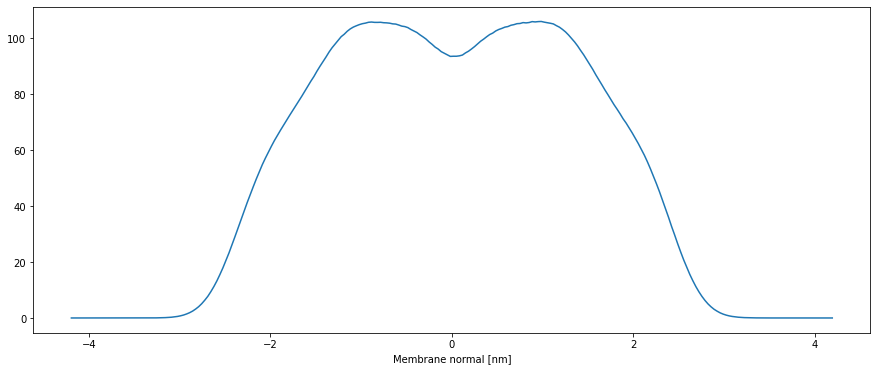

Loading the trajectory takes   0.298935 s
Creating the electron mapping dictonary takes   0.000021 s
Calculating the density takes  72.872091 s


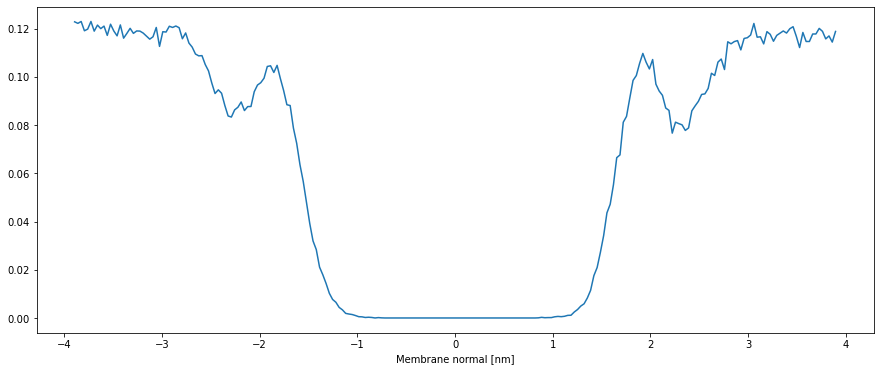

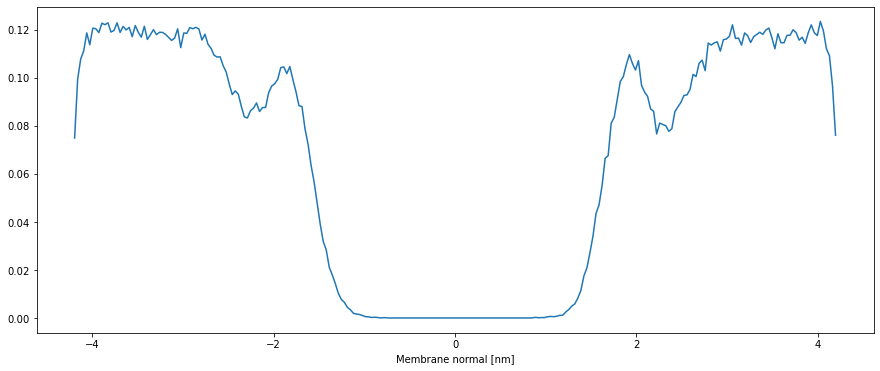

Loading the trajectory takes   0.294087 s
Creating the electron mapping dictonary takes   0.000143 s
Calculating the density takes  94.927795 s


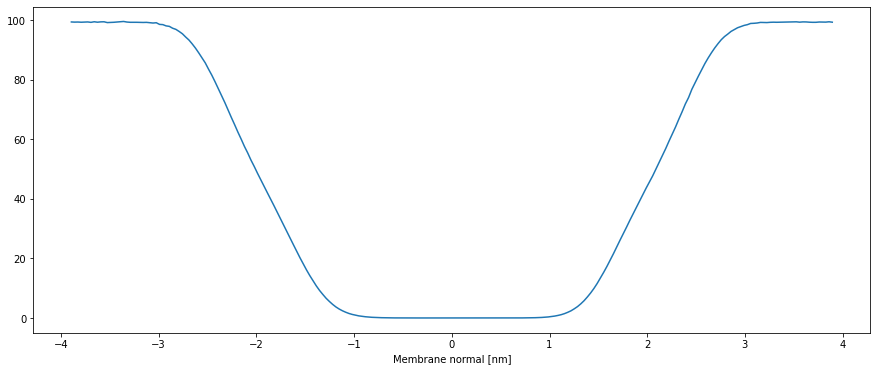

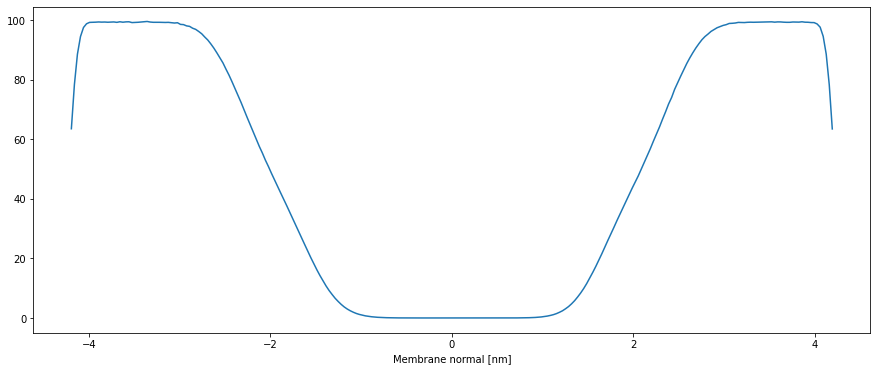

In [47]:
path="/home/nenciric/Downloads/"
name="PN_model_310K_TIP3P_ECC_ions_113mM_calcium"

FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_CA',"resname POPC","resname CA","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname SOL","number")

Loading the trajectory takes   0.467985 s
Creating the electron mapping dictonary takes   0.000173 s
Calculating the density takes  28.278697 s


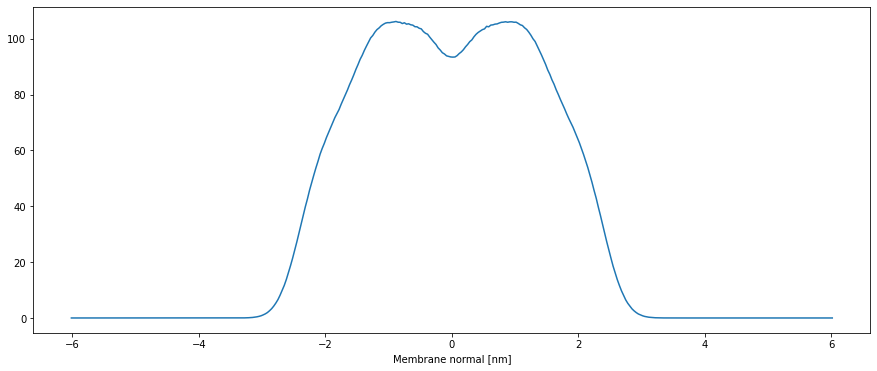

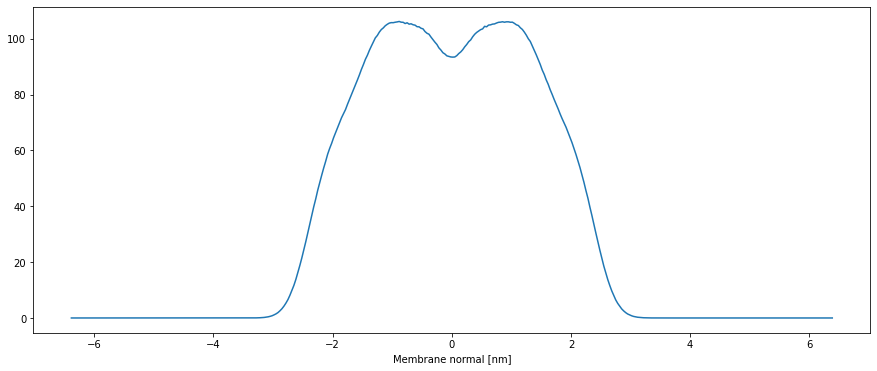

Loading the trajectory takes   0.450389 s
Creating the electron mapping dictonary takes   0.000021 s
Calculating the density takes  21.069886 s


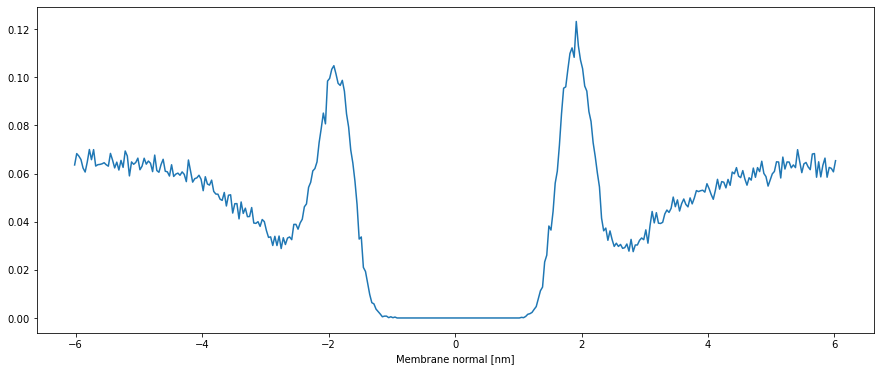

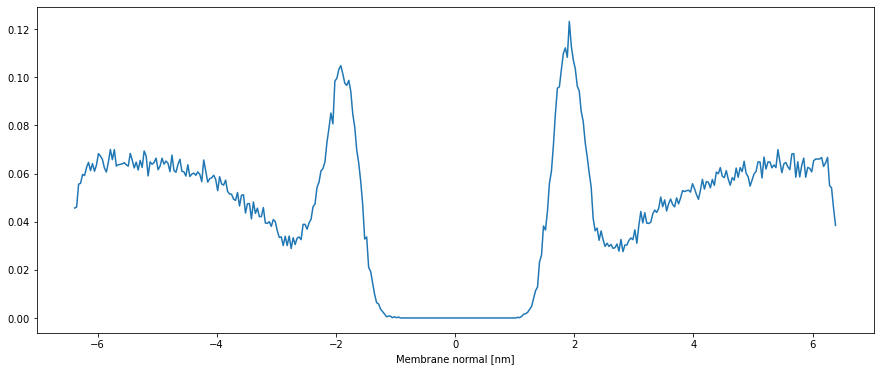

Loading the trajectory takes   0.451218 s
Creating the electron mapping dictonary takes   0.000287 s
Calculating the density takes  37.849131 s


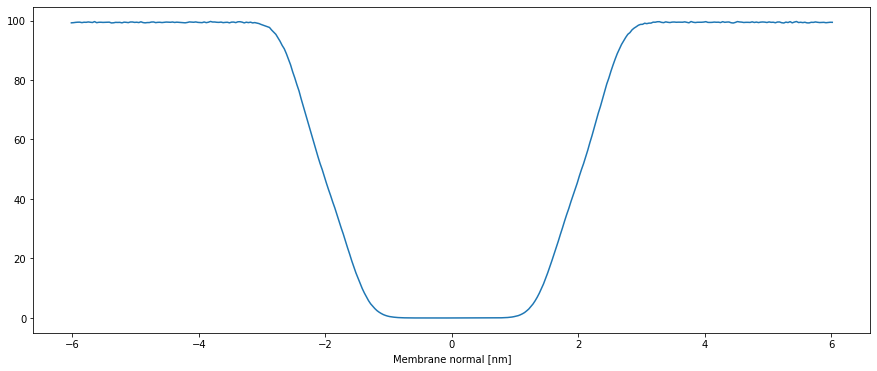

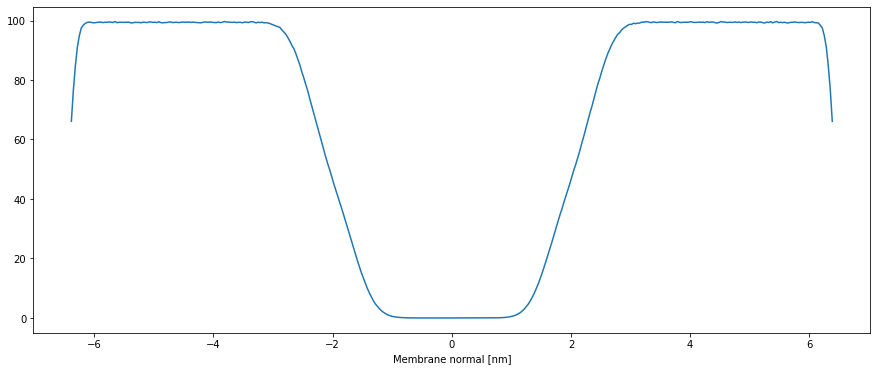

In [51]:
path="/home/nenciric/Downloads/"
name="PN_model_310K_TIP3P_ECC_ions_113mM_calcium_bigBox"

FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_CA',"resname POPC","resname CA","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname SOL","number")

In [42]:
sys.path.insert(1,'/home/nenciric/Documents/git/charged_molecules_binding/simulations_list/')
import AnalysisToolbox as AT
systems=["PN"]

In [48]:
for file in os.listdir(path):
    input_corr_file = path+os.fsdecode(file)
    for system in systems:
        if fnmatch.fnmatch(os.fsdecode(file), "*"+system+"*"):
            newcomer=AT.AnalysisToolbox(path,os.fsdecode(file),system,["ORDER_PARAMETER","BOX_DIMENSIONS"])
            newcomer.add_new_folders()
            #newcomer.analysis_module()


<Universe with 53854 atoms>
Got into checking
/home/nenciric/Downloads/
great success!!!
<Universe with 80908 atoms>
Got into checking
/home/nenciric/Downloads/
great success!!!
